In [ ]:
import numpy as np 
import tensorflow as tf
import scipy
from scipy import sparse
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 5.0 MB/s 


In [ ]:
cust_id_file = open('drive/MyDrive/TrainDy/cust_list.npy','rb')
cust_id_list = pickle.load(cust_id_file)
cust_id_list.shape

(581186,)

In [ ]:
prod_id_file = open('drive/MyDrive/TrainDy/prod_list.npy','rb')
prod_id_list = pickle.load(prod_id_file)
prod_id_list.shape

(21404,)

In [ ]:
cust_sparse = scipy.sparse.load_npz('drive/MyDrive/TrainDy/cust_purchase_hist_sparse_matrix.npz')


In [ ]:
file = open("drive/MyDrive/TrainDy/cust_18_up.pkl",'rb')
cust_features = pickle.load(file)
cust_features = cust_features.fillna(0)

In [ ]:
cust_features.head()

In [ ]:
cust_id_to_label = cust_features.loc[:, cust_features.columns == 'customer_id']

In [ ]:
cust_features = cust_features.loc[:, (cust_features.columns != 'customer_id') & (cust_features.columns != 'article_id') & (cust_features.columns != 'sales_channel_id')]
cust_features = cust_features.to_numpy()
cust_features = cust_features[:,:8]
print(cust_features[:10])

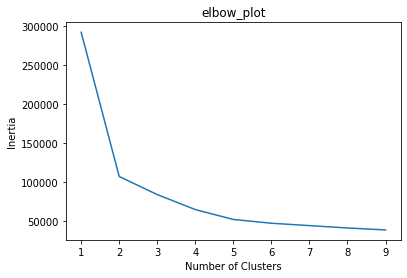

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def elbow_point_plot(cluster, errors):
    """
    This function helps create a plot representing the tradeoff between the
    number of clusters and the inertia values.

    :param cluster: 1D np array that represents K (the number of clusters)
    :param errors: 1D np array that represents the inertia values
    """
    plt.clf()
    plt.plot(cluster, errors)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('elbow_plot')
    plt.show()


def sk_learn_cluster(X, K):
    """
    Performs k-means clustering using library functions (scikit-learn). You can
    experiment with different initialization settings, but please initialize
    without any optional arguments (other than n_clusters) before submitting.

    :param X: 2D np array containing features of the songs
    :param K: number of clusters
    :return: a tuple of (cluster centroids, indices for each data point)
    """
    # TODO:
    km = KMeans(n_clusters=K)
    res = km.fit(X)

    return (res.cluster_centers_, res.labels_, res.inertia_)


def min_max_scale(data):
    """
    Pre-processes the data by performing MinMax scaling.

    MinMax scaling prevents different scales of the data features from
    influencing distance calculations.

    MinMax scaling is performed by
        X_new = (X - X_min) / (X_max - X_min),

    where X_new is the newly scaled value, X_min is the minimum and X_max is the
    maximum along a single feature column.

    :param data: 2D numpy array of raw data
    :return: preprocessed data
    """
    # TODO: Standardize each column's features by subtracting the columns min and
    # dividing by the column's max - the column's min
    data = (data - np.amin(data,axis=0))/(data.ptp(axis=0) + 1e-5)
    return data


def one_hot(labels, class_size):
    """
    Create one hot label matrix of size (N, C)

    Inputs:
    - labels: Labels Tensor of shape (N,) representing a ground-truth label
    for each MNIST image
    - class_size: Scalar representing of target classes our dataset 
    Returns:
    - targets: One-hot label matrix of (N, C), where targets[i, j] = 1 when 
    the ground truth label for image i is j, and targets[i, :j] & 
    targets[i, j + 1:] are equal to 0
    """
    targets = np.zeros((labels.shape[0], class_size))
    for i, label in enumerate(labels):
        targets[i, label] = 1
    targets = tf.convert_to_tensor(targets)
    targets = tf.cast(targets, tf.float32)
    return targets

scaled_data = min_max_scale(cust_features)
errors = []
k_val = []
for i in range(1,10):
    cent,ids,inert = sk_learn_cluster(scaled_data,i)
    errors.append(inert)
    k_val.append(i)

elbow_point_plot(k_val,errors)


In [ ]:
scaled_data = min_max_scale(cust_features)
cent, ids, inert = sk_learn_cluster(scaled_data, 5)

In [ ]:
cust_id_to_label['labels'] = ids

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation, Input
from tensorflow.math import exp, sqrt, square
from tensorflow.keras import regularizers


class CVAE(tf.keras.Model):
    def __init__(self, input_size, latent_size=15):
        super(CVAE, self).__init__()
        self.input_size = input_size# H*W
        self.latent_size =  latent_size# Z
        self.hidden_dim = 1024  # H_d
        self.encoder = Sequential(
                [
        Dense(self.hidden_dim, activation="relu", name="layer1",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),),
        Dense(self.hidden_dim, activation="relu", name="layer2",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),),
        Dense(self.hidden_dim, activation="relu", name="layer3",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),),
    ]
        )
        self.mu_layer = Dense(self.latent_size, name="mu_layer")
        self.logvar_layer = Dense(self.latent_size, name="logvar_layer")
        self.decoder = Sequential(
                [
        Dense(self.hidden_dim, activation="relu", name="dec_layer1",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4)),
        Dense(self.hidden_dim, activation="relu", name="dec_layer2",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4)),
        Dense(self.hidden_dim, activation="relu", name="dec_layer3",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4)),
        Dense(self.input_size, name="dec_layer4", activation='sigmoid'),
    ]
        )

        ############################################################################################
        # TODO: Implement the fully-connected encoder architecture described in the notebook.      #
        # Specifically, self.encoder should be a network that inputs a batch of input images of    #
        # shape (N, 1, H, W) into a batch of hidden features of shape (N, H_d). Set up             #
        # self.mu_layer and self.logvar_layer to be a pair of linear layers that map the hidden    #
        # features into estimates of the mean and log-variance of the posterior over the latent    #
        # vectors; the mean and log-variance estimates will both be tensors of shape (N, Z).       #
        ############################################################################################
        # Replace "pass" statement with your code

        ############################################################################################
        # TODO: Implement the fully-connected decoder architecture described in the notebook.      #
        # Specifically, self.decoder should be a network that inputs a batch of latent vectors of  #
        # shape (N, Z) and outputs a tensor of estimated images of shape (N, 1, H, W).             #
        ############################################################################################
        # Replace "pass" statement with your code

        ############################################################################################
        #                                      END OF YOUR CODE                                    #
        ############################################################################################

    def call(self, x,c):
        """
        Performs forward pass through FC-VAE model by passing image through 
        encoder, reparametrize trick, and decoder models
    
        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)
        
        Returns:
        - x_hat: Reconstruced input data of shape (N,1,H,W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent space dimension
        - logvar: Matrix representing estimataed variance in log-space (N, Z), with Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None
        ############################################################################################
        # TODO: Implement the forward pass by following these steps                                #
        # (1) Pass the input batch through the encoder model to get posterior mu and logvariance   #
        # (2) Reparametrize to compute  the latent vector z                                        #
        # (3) Pass z through the decoder to resconstruct x                                         #
        ############################################################################################
        # Replace "pass" statement with your code
        
        x_hat = None
        mu = None
        logvar = None
        
        x = tf.cast(x, tf.float32)
        conditioned_x = tf.concat([x,c],axis = 1)
        encoded_input = self.encoder(conditioned_x)
        mu = self.mu_layer(encoded_input)
        logvar = self.logvar_layer(encoded_input)
        z = reparametrize(mu, logvar)
        conditioned_z = tf.concat([z,c],axis = 1)
        x_hat = self.decoder(conditioned_z)

        ############################################################################################
        #                                      END OF YOUR CODE                                    #
        ############################################################################################
        return x_hat, mu, logvar



def reparametrize(mu, logvar):
    """
    Differentiably sample random Gaussian data with specified mean and variance using the
    reparameterization trick.

    Suppose we want to sample a random number z from a Gaussian distribution with mean mu and
    standard deviation sigma, such that we can backpropagate from the z back to mu and sigma.
    We can achieve this by first sampling a random value epsilon from a standard Gaussian
    distribution with zero mean and unit variance, then setting z = sigma * epsilon + mu.

    For more stable training when integrating this function into a neural network, it helps to
    pass this function the log of the variance of the distribution from which to sample, rather
    than specifying the standard deviation directly.

    Inputs:
    - mu: Tensor of shape (N, Z) giving means
    - logvar: Tensor of shape (N, Z) giving log-variances

    Returns: 
    - z: Estimated latent vectors, where z[i, j] is a random value sampled from a Gaussian with
         mean mu[i, j] and log-variance logvar[i, j].
    """
    epsilon = tf.random.normal([mu.shape[0],mu.shape[1]])
    sigma = tf.math.sqrt(tf.math.exp(logvar))
    z = sigma * epsilon + mu
    return z



def bce_function(x_hat, x):
    """
    Computes the reconstruction loss of the VAE.
    
    Inputs:
    - x_hat: Reconstructed input data of shape (N, 1, H, W)
    - x: Input data for this timestep of shape (N, 1, H, W)
    
    Returns:
    - reconstruction_loss: Tensor containing the scalar loss for the reconstruction loss term.
    """
    bce_fn = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, 
        reduction=tf.keras.losses.Reduction.SUM,
    )
    reconstruction_loss = bce_fn(x, x_hat) * x.shape[-1]  # Sum over all loss terms for each data point. This looks weird, but we need this to work...
    return reconstruction_loss

def loss_function(x_hat, x, mu, logvar):
    """
    Computes the negative variational lower bound loss term of the VAE (refer to formulation in notebook).
    Returned loss is the average loss per sample in the current batch.

    Inputs:
    - x_hat: Reconstructed input data of shape (N, 1, H, W)
    - x: Input data for this timestep of shape (N, 1, H, W)
    - mu: Matrix representing estimated posterior mu (N, Z), with Z latent space dimension
    - logvar: Matrix representing estimated variance in log-space (N, Z), with Z latent space dimension
    
    Returns:
    - loss: Tensor containing the scalar loss for the negative variational lowerbound
    """
    #reconstruction_loss = bce_function(x_hat, x)
    kl_divergence = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    csim = tf.keras.losses.CosineSimilarity()
    loss = 30*csim(x,x_hat)+kl_divergence
    
    ################################################################################################
    # TODO: Compute negative variational lowerbound loss as described in the notebook              #
    ################################################################################################
    # Replace "pass" statement with your code
    
    ################################################################################################
    #                            END OF YOUR CODE                                                  #
    ################################################################################################
    return loss/x.shape[0]


In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    X = sparse.csr_matrix(X)  
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def train_vae(model, X, is_cvae=False):
    """
    Train your VAE with one epoch.

    Inputs:
    - model: Your VAE instance.
    - train_loader: A tf.data.Dataset of MNIST dataset.
    - args: All arguments.
    - is_cvae: A boolean flag for Conditional-VAE. If your model is a Conditional-VAE,
    set is_cvae=True. If it's a Vanilla-VAE, set is_cvae=False.

    Returns:
    - total_loss: Sum of loss values of all batches.
    """
    total_loss = 0
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    for batch in range(50):
        batch_inputs = cust_sparse[batch*1000:1000*batch +1000,:].toarray()
        batch_labels_id = cust_id_list[batch*1000:1000*batch +1000]
        batch_labels = one_hot(cust_id_to_label[cust_id_to_label['customer_id'].isin(batch_labels_id)]['labels'].to_numpy(),5)
        with tf.GradientTape() as tape:
            if not is_cvae:
                x_hat, mu, logvar = model.call(batch_inputs, batch_labels)
                batch_inputs = tf.cast(batch_inputs, tf.float32)
            loss = loss_function(x_hat, batch_inputs, mu, logvar)
            total_loss += loss
        
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    print(x_hat[0])

    return total_loss



model = CVAE(21404, latent_size=512)

for epoch_id in range(10):
    total_loss = train_vae(model, cust_sparse, is_cvae=False)
    #print(f"Train Epoch: {epoch_id} \tLoss: {total_loss/len(train_dataset):.6f}")
    print("Train Epoch: " + str(epoch_id) + '    Loss: ' + str(total_loss/50))

tf.Tensor([0.99993825 0.9529606  0.9731382  ... 0.5092013  0.24263722 0.79343534], shape=(21404,), dtype=float32)
Train Epoch: 0    Loss: tf.Tensor(0.0007572991, shape=(), dtype=float32)
tf.Tensor([0.99999976 0.20748478 0.98411477 ... 0.07657436 0.04560762 0.26737702], shape=(21404,), dtype=float32)
Train Epoch: 1    Loss: tf.Tensor(-0.0011165268, shape=(), dtype=float32)
tf.Tensor([0.9999994  0.28702718 0.5979698  ... 0.07381888 0.03005882 0.25583845], shape=(21404,), dtype=float32)
Train Epoch: 2    Loss: tf.Tensor(-0.0012417742, shape=(), dtype=float32)
tf.Tensor([0.99999094 0.18002075 0.21014291 ... 0.06587173 0.0335303  0.24045797], shape=(21404,), dtype=float32)
Train Epoch: 3    Loss: tf.Tensor(-0.0012997994, shape=(), dtype=float32)
tf.Tensor([0.9999465  0.20805258 0.31651577 ... 0.05931315 0.03921026 0.22707179], shape=(21404,), dtype=float32)
Train Epoch: 4    Loss: tf.Tensor(-0.001343618, shape=(), dtype=float32)
tf.Tensor([0.99995935 0.16916797 0.20830067 ... 0.03794413 0.0

In [ ]:
model.save_weights("my_model_3.h5")

In [ ]:

def predict(cust_id, model, latent_size):
    """
    Call this only if the model is VAE!
    Generate 10 images from random vectors.
    Show the generated images from your trained VAE.
    Image will be saved to outputs/show_vae_images.pdf

    Inputs:
    - model: Your trained model.
    - latent_size: Latent size of your model.
    """
    # Generated images from vectors of random values.

    num_generation = 5
    num_classes = 5
    num_per_class = num_generation // num_classes
    c = tf.eye(num_classes) # [one hot labels for 0-9]
    z = []
    label = cust_id_to_label[cust_id_to_label['customer_id']==cust_id]['labels'].to_numpy()[0]
    curr_c = c[label]
    curr_c = tf.broadcast_to(curr_c, [num_per_class, len(curr_c)])
    curr_z = tf.random.normal(shape=[num_per_class,latent_size])
    curr_z = tf.concat([curr_z,curr_c], axis=-1)
    z.append(curr_z)
    z = np.concatenate(z)
    samples = model.decoder(z).numpy()
    return np.array(samples[0])


def get_top_n_products(n, pred):
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    indices = np.where(pred==1)
    recommended_prod_ids = prod_id_list[indices]
    return recommended_prod_ids
      

pred = predict('00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', model, 512)
print(pred)
top_rec = get_top_n_products(20,pred)
print(len(top_rec))

[0.9996847  0.10322639 0.18288785 ... 0.02937494 0.01800176 0.09993609]
166


In [ ]:
transact_2019 = open('/content/drive/MyDrive/TrainDy/TAC_19.pkl', 'rb')
transactions_data = pickle.load(transact_2019)

In [ ]:
transactions_data.head()

In [ ]:
transactions_data = transactions_data[transactions_data['customer_id'].isin(cust_id_list)]
transactions_data.head()

,customer_id,product_code
4411262,0005f3aab821000881d74b72fde2d9b3e4742cf8613668...,304766
4411265,000ca60ca6d8de6d3b4689e2da829d69db5947bd89084c...,662916
4411266,000ca60ca6d8de6d3b4689e2da829d69db5947bd89084c...,740909
4411267,001ea5b25c75e6490705b22abb670e08007967c631a4c5...,666382
4411270,00497856651e5483f26917703886e95c6e299a74928740...,665532


In [ ]:
unique_ret_cust = transactions_data['customer_id'].unique()

In [ ]:
recall = 0
count = 0
for c in unique_ret_cust[:100]:
  print(count)
  count+=1
  pred = predict(c, model, 512)
  top_rec = get_top_n_products(20,pred)
  # print("Number of products she purchased: ",transactions_data[(transactions_data['customer_id']==c)].shape[0])
  a = transactions_data[(transactions_data['customer_id']==c)].shape[0]
  # print("Number of products matched: ",transactions_data[(transactions_data['customer_id']==c)& (transactions_data['product_code'].isin(top_rec))].shape[0])
  b = transactions_data[(transactions_data['customer_id']==c)&(transactions_data['product_code'].isin(top_rec))].shape[0]
  print(b,len(top_rec))
  if b>0:
    recall += 1

  

0
0 163
1
0 164
2
1 166
3
3 164
4
0 164
5
0 163
6
6 168
7
0 167
8
11 167
9
3 166
10
2 167
11
2 165
12
0 165
13
0 168
14
1 164
15
3 164
16
12 163
17
3 165
18
6 169
19
0 166
20
0 164
21
6 167
22
0 165
23
1 162
24
4 165
25
4 165
26
2 163
27
12 167
28
4 164
29
2 167
30
0 166
31
0 169
32
4 166
33
4 168
34
2 167
35
2 164
36
1 166
37
1 166
38
4 168
39
9 165
40
1 165
41
0 165
42
1 165
43
8 166
44
0 166
45
3 168
46
0 166
47
9 165
48
1 167
49
4 167
50
1 165
51
3 166
52
1 165
53
1 165
54
6 167
55
1 164
56
0 163
57
2 166
58
8 163
59
0 165
60
14 164
61
1 162
62
0 164
63
1 166
64
9 164
65
0 165
66
16 163
67
8 168
68
2 166
69
2 169
70
0 163
71
7 164
72
0 164
73
0 166
74
5 167
75
2 167
76
0 165
77
2 167
78
3 165
79
0 162
80
2 167
81
0 165
82
5 166
83
1 168
84
4 166
85
4 165
86
6 166
87
9 163
88
3 163
89
1 165
90
13 165
91
0 165
92
2 166
93
11 167
94
0 164
95
3 165
96
3 165
97
5 165
98
2 166
99
2 163


In [ ]:
print(recall)
success_score = recall/100
print(success_score)

73
0.73


# CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(10, True, 1)
for _ in cust_id_list.shape[0]/10:
  for train_ind, test_ind in kfold.split(len(cust_sparse)):
    train = cust_sparse[train_ind].toarray()
    test = unique_ret_cust[test_ind]
    for epoch_id in range(10):
      total_loss = train_vae(model, train, is_cvae=False)
      #print(f"Train Epoch: {epoch_id} \tLoss: {total_loss/len(train_dataset):.6f}")
      print("Train Epoch: " + str(epoch_id) + '    Loss: ' + str(total_loss/50))
    for c in test:
      pred = predict(c, model, 512)
      top_rec = get_top_n_products(20,pred)
      a = transactions_data[(transactions_data['customer_id']==c)].shape[0]
      b = transactions_data[(transactions_data['customer_id']==c)&(transactions_data['product_code'].isin(top_rec))].shape[0]
      print(b,len(top_rec))
      if b>0:
        recall += 1
    success_score = recall/len(test)
